In [1]:
!pip install gensim==4.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 96.7 MB/s eta 0:00:00
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20431 sha256=2b0794b3d5d6df1342eddc9a6f2e3beea755182818b6bb85f1e68ceecf27db6d
  Stored in directory: /root/.cache/pip/wheels/69/f5/e5/18ad53fe1ed6b2af9fad05ec052e4acbac8e92441df44bad2e
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3506 sha256=655bacc9bc8ad3b376dc2f8714ac120f88dc7a362e61dcc02430f7d00a588e0e
  Stored in directory: /root/.cach

In [2]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Importing text Processing Libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter

# Importing sentiment Analysis Libraries
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Importing machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Topic Modeling
import gensim
from gensim import corpora
from gensim.models import LdaModel

nltk_downloads = ['punkt', 'stopwords', 'wordnet', 'omw-1.4', 'vader_lexicon','punkt_tab']
for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)
    except:
        pass


# EDA

In [2]:
df= pd.read_csv("product_reviews_mock_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ReviewID    1000 non-null   object
 1   ProductID   1000 non-null   object
 2   UserID      1000 non-null   object
 3   Rating      1000 non-null   int64 
 4   ReviewText  1000 non-null   object
 5   ReviewDate  1000 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


In [4]:
df.isnull().sum()

,0
ReviewID,0
ProductID,0
UserID,0
Rating,0
ReviewText,0
ReviewDate,0


In [5]:
df.head(5)

,ReviewID,ProductID,UserID,Rating,ReviewText,ReviewDate
0,REV2000,Product_E,User_114,4,fantastic. wonderful experience.,2023-04-17
1,REV2001,Product_C,User_186,2,broke easily. awful.,2023-11-27
2,REV2002,Product_E,User_101,3,met expectations. five stars.,2023-12-10
3,REV2003,Product_A,User_175,5,very satisfied. wonderful experience.,2023-11-10
4,REV2004,Product_C,User_158,1,worst purchase. one star.,2024-05-25


<Axes: xlabel='Rating', ylabel='Count'>

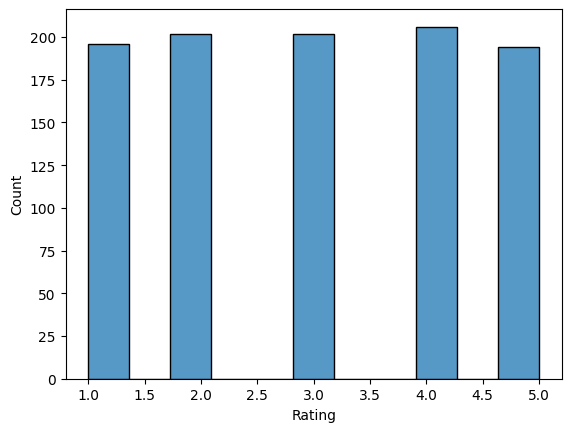

In [6]:
sns.histplot(df['Rating'])

In [7]:
df['ReviewDate'] = pd.to_datetime(df['ReviewDate'])
df['Year'] = df['ReviewDate'].dt.year
df['Month'] = df['ReviewDate'].dt.month

print(f"\nDate range: {df['ReviewDate'].min()} to {df['ReviewDate'].max()}")
print(f"Rating distribution:\n{df['Rating'].value_counts().sort_index()}")



Date range: 2023-01-01 00:00:00 to 2024-12-30 00:00:00
Rating distribution:
1    196
2    202
3    202
4    206
5    194
Name: Rating, dtype: int64


# Text Preprocessing

In [8]:
class OptimizedTextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        # Add custom stop words for product reviews
        custom_stops = {'product', 'item', 'thing', 'stuff', 'really', 'quite', 'pretty'}
        self.stop_words.update(custom_stops)
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Enhanced text cleaning for better ML performance"""
        if pd.isna(text):
            return ""

        # Converting text to lowercase
        text = text.lower()

        # Removing URLs, mentions, hashtags
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)

        # Replacing contractions
        contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will", "'d": " would"
        }
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)

        # Removing punctuation but keeping important sentiment indicators
        text = re.sub(r'[^\w\s!?]', ' ', text)
        text = re.sub(r'[!]{2,}', ' very_positive ', text)
        text = re.sub(r'[?]{2,}', ' confused ', text)

        # Removing numbers but keeping words with numbers
        text = re.sub(r'\b\d+\b', '', text)

        # Removing extra whitespace
        text = ' '.join(text.split())

        return text

    def advanced_tokenize(self, text):
        tokens = word_tokenize(text)

        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stop_words
            and len(token) > 2
            and token.isalpha()
        ]

        return tokens

    def preprocess_for_ml(self, text):
        cleaned = self.clean_text(text)
        tokens = self.advanced_tokenize(cleaned)
        return ' '.join(tokens)


preprocessor = OptimizedTextPreprocessor()

# Applying enhanced preprocessing
df['cleaned_text'] = df['ReviewText'].apply(preprocessor.preprocess_for_ml)

print("Enhanced preprocessing examples:")
for i in range(3):
    print(f"\nOriginal: {df.iloc[i]['ReviewText']}")
    print(f"Enhanced: {df.iloc[i]['cleaned_text']}")


Enhanced preprocessing examples:

Original: fantastic. wonderful experience.
Enhanced: fantastic wonderful experience

Original: broke easily. awful.
Enhanced: broke easily awful

Original: met expectations. five stars.
Enhanced: met expectation five star


# Sentiment Analysis

In [9]:
# Initializing sentiment analyzers
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Getting VADER sentiment scores"""
    scores = analyzer.polarity_scores(text)
    return scores

def categorize_sentiment(compound_score):
    """sentiment categorization"""
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def rating_to_sentiment(rating):
    """Converting ratings to sentiment labels"""
    if rating >= 4:
        return 'Positive'
    elif rating <= 2:
        return 'Negative'
    else:
        return 'Neutral'

# Applying VADER (for validation and ensemble)
print("Applying VADER sentiment analysis...")
df['vader_scores'] = df['ReviewText'].apply(get_vader_sentiment)
df['vader_compound'] = df['vader_scores'].apply(lambda x: x['compound'])
df['vader_sentiment'] = df['vader_compound'].apply(categorize_sentiment)

# Creating ground truth labels
df['rating_sentiment'] = df['Rating'].apply(rating_to_sentiment)

print(f"VADER-Rating Correlation: {df['Rating'].corr(df['vader_compound']):.3f}")

Applying VADER sentiment analysis...
VADER-Rating Correlation: 0.829


# Machine Learning Models

In [10]:
# Preparing data for ML
X = df['cleaned_text']
y = df['rating_sentiment']

# feature extraction
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 3),
    min_df=1,
    max_df=0.95,
    sublinear_tf=True,
    strip_accents='unicode'
)

X_tfidf = tfidf.fit_transform(X)
print(f"Feature matrix shape: {X_tfidf.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=42, stratify=y
)

Creating TF-IDF features...
Feature matrix shape: (1000, 1558)


## Logistic Regression

In [11]:
# Hyperparameter tuning for Logistic Regression
lr_params = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000, 2000],
    'class_weight': [None, 'balanced']
}

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
lr_base = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr_base, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)

# Best Logistic Regression model
best_lr = lr_grid.best_estimator_
lr_pred = best_lr.predict(X_test)
lr_pred_proba = best_lr.predict_proba(X_test)

print(f"Best LR Parameters: {lr_grid.best_params_}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.3f}")
print(f"Cross-validation Score: {lr_grid.best_score_:.3f}")

Best LR Parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'lbfgs'}
Logistic Regression Accuracy: 0.973
Cross-validation Score: 0.961


## Naive Bayes

In [12]:
# Hyperparameter tuning for Naive Bayes
nb_params = {'alpha': [0.1, 0.5, 1.0, 2.0]}
nb_base = MultinomialNB()
nb_grid = GridSearchCV(nb_base, nb_params, cv=5, scoring='accuracy')
nb_grid.fit(X_train, y_train)

best_nb = nb_grid.best_estimator_
nb_pred = best_nb.predict(X_test)

print(f"Best NB Parameters: {nb_grid.best_params_}")
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, nb_pred):.3f}")

Best NB Parameters: {'alpha': 0.1}
Naive Bayes Accuracy: 0.930


## Ensemble Model

In [13]:
# Creating ensemble model with optimized models
ensemble = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('nb', best_nb)
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)

print(f"Ensemble Accuracy: {accuracy_score(y_test, ensemble_pred):.3f}")

Ensemble Accuracy: 0.957


## Model Performance analysis

In [14]:
models = {
    'Logistic Regression': (best_lr, lr_pred),
    'Naive Bayes': (best_nb, nb_pred),
    'Ensemble (Combined)': (ensemble, ensemble_pred)
}

for name, (model, predictions) in models.items():
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_test, predictions):.3f}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))


Logistic Regression:
Accuracy: 0.973
Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99       119
     Neutral       0.92      0.95      0.94        61
    Positive       0.98      0.97      0.98       120

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300


Naive Bayes:
Accuracy: 0.930
Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96       119
     Neutral       0.87      0.77      0.82        61
    Positive       0.93      0.98      0.96       120

    accuracy                           0.93       300
   macro avg       0.92      0.90      0.91       300
weighted avg       0.93      0.93      0.93       300


Ensemble (Combined):
Accuracy: 0.957
Classification Report:
              precision    recall  f1-score   support

    Nega

## Feature Analysis

In [15]:
feature_names = tfidf.get_feature_names_out()
lr_coef = best_lr.coef_

print("Most Important Features by Class:")
for i, class_name in enumerate(best_lr.classes_):
    print(f"\n{class_name} sentiment indicators:")
    # Getting top features for this class
    top_features_idx = np.argsort(lr_coef[i])[-10:][::-1]
    for idx in top_features_idx:
        print(f"  {feature_names[idx]}: {lr_coef[i][idx]:.3f}")

Most Important Features by Class:

Negative sentiment indicators:
  awful: 3.153
  terrible: 3.109
  disappointed: 3.072
  bad experience: 2.627
  would: 2.447
  would recommend: 2.447
  difficult: 2.360
  difficult use: 2.360
  one: 2.290
  one star: 2.290

Neutral sentiment indicators:
  okay: 5.177
  average: 3.650
  work expected: 3.137
  expected: 3.137
  met: 2.916
  met expectation: 2.916
  con: 1.875
  pro con: 1.875
  pro: 1.875
  decent: 1.863

Positive sentiment indicators:
  fantastic: 3.486
  love: 3.209
  work perfectly: 2.963
  perfectly: 2.963
  satisfied: 2.899
  amazing: 2.669
  amazing feature: 2.669
  excellent quality: 2.540
  excellent: 2.540
  highly recommend: 2.464


# Final Prediction System

In [16]:
class ProductionSentimentAnalyzer:
    def __init__(self, model, vectorizer, preprocessor):
        self.model = model
        self.vectorizer = vectorizer
        self.preprocessor = preprocessor

    def predict_sentiment(self, text):
        """Predict sentiment for new text"""
        # Preprocessing
        cleaned_text = self.preprocessor.preprocess_for_ml(text)

        # Vectorizigg
        text_vector = self.vectorizer.transform([cleaned_text])

        # Predicting
        prediction = self.model.predict(text_vector)[0]
        probability = self.model.predict_proba(text_vector)[0]

        # Gettingconfidence score
        confidence = max(probability)

        return {
            'sentiment': prediction,
            'confidence': confidence,
            'probabilities': {
                class_: prob
                for class_, prob in zip(self.model.classes_, probability)
            }
        }

    def batch_predict(self, texts):
        """Predict sentiment for multiple texts"""
        results = []
        for text in texts:
            results.append(self.predict_sentiment(text))
        return results

# Initializing production analyzer with best model
production_analyzer = ProductionSentimentAnalyzer(best_lr, tfidf, preprocessor)

# Testing with sample predictions
print("Testing Production Analyzer:")
test_reviews = [
    "This product is absolutely amazing! Love it!",
    "Terrible quality, broke after one day",
    "It's okay, nothing special but works fine"
]

for review in test_reviews:
    result = production_analyzer.predict_sentiment(review)
    print(f"\nReview: {review}")
    print(f"Predicted: {result['sentiment']} (Confidence: {result['confidence']:.3f})")

Testing Production Analyzer:

Review: This product is absolutely amazing! Love it!
Predicted: Positive (Confidence: 0.994)

Review: Terrible quality, broke after one day
Predicted: Negative (Confidence: 0.995)

Review: It's okay, nothing special but works fine
Predicted: Neutral (Confidence: 0.998)


# Visulaization

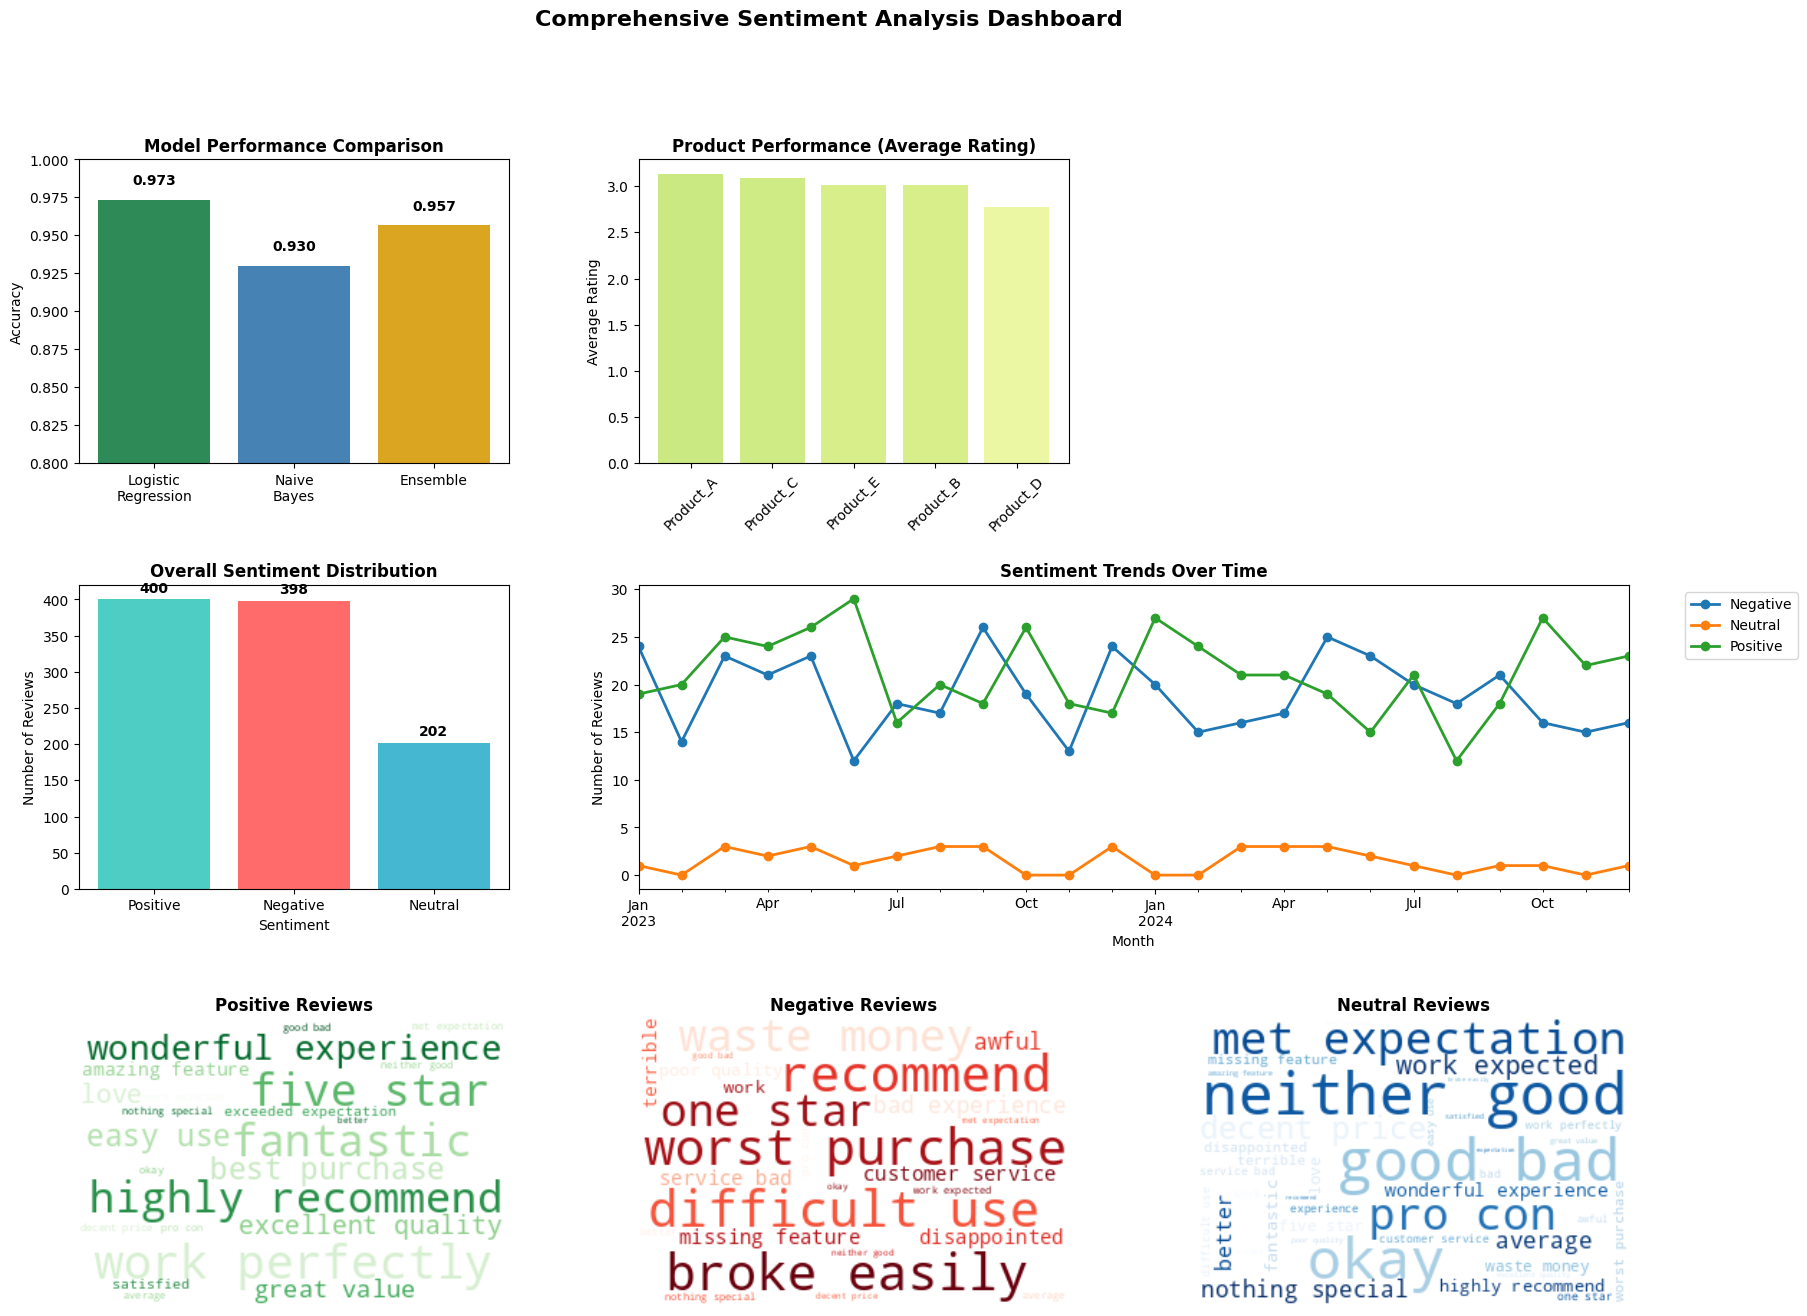

In [17]:
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

# 1. Model Performance Comparison
ax1 = fig.add_subplot(gs[0, 0])
models_acc = [accuracy_score(y_test, lr_pred), accuracy_score(y_test, nb_pred),
              accuracy_score(y_test, ensemble_pred)]
model_names = ['Logistic\nRegression', 'Naive\nBayes', 'Ensemble']
bars = ax1.bar(model_names, models_acc, color=['#2E8B57', '#4682B4', '#DAA520'])
ax1.set_title('Model Performance Comparison', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.8, 1.0)
for bar, acc in zip(bars, models_acc):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', fontweight='bold')

# 2. Product Performance Analysis
ax2 = fig.add_subplot(gs[0, 1])
product_sentiment = df.groupby('ProductID')['Rating'].mean().sort_values(ascending=False)
bars = ax2.bar(product_sentiment.index, product_sentiment.values,
               color=plt.cm.RdYlGn(product_sentiment.values/5))
ax2.set_title('Product Performance (Average Rating)', fontweight='bold')
ax2.set_ylabel('Average Rating')
ax2.tick_params(axis='x', rotation=45)

# 3. Sentiment Trends Over Time
ax3 = fig.add_subplot(gs[1, 1:])
monthly_data = df.groupby([df['ReviewDate'].dt.to_period('M'), 'vader_sentiment']).size().unstack(fill_value=0)
if len(monthly_data) > 1:
    monthly_data.plot(kind='line', ax=ax3, marker='o', linewidth=2)
    ax3.set_title('Sentiment Trends Over Time', fontweight='bold')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Number of Reviews')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    ax3.text(0.5, 0.5, 'Insufficient time periods\nfor trend analysis',
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Sentiment Trends Over Time', fontweight='bold')

# 4. Sentiment Distribution
ax4 = fig.add_subplot(gs[1, 0])
sentiment_counts = df['rating_sentiment'].value_counts()
colors = ['#4ECDC4', '#FF6B6B', '#45B7D1']
bars = ax4.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
ax4.set_title('Overall Sentiment Distribution', fontweight='bold')
ax4.set_ylabel('Number of Reviews')
ax4.set_xlabel('Sentiment')
for bar, count in zip(bars, sentiment_counts.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{count}', ha='center', fontweight='bold')

# Word Clouds for Positive, Negative, and Neutral Reviews
sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['Greens', 'Reds', 'Blues']
for i, (sentiment, cmap) in enumerate(zip(sentiments, colors)):
    ax = fig.add_subplot(gs[2, i])
    sentiment_text = ' '.join(df[df['rating_sentiment'] == sentiment]['cleaned_text'])
    if sentiment_text.strip():
        wordcloud = WordCloud(width=300, height=200, background_color='white',
                             colormap=cmap).generate(sentiment_text)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'{sentiment} Reviews', fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'No {sentiment}\nReviews', ha='center', va='center')
        ax.set_title(f'{sentiment} Reviews', fontweight='bold')
    ax.axis('off')

plt.suptitle('Comprehensive Sentiment Analysis Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()